# Gibbs Sampling and LDA
    Jonathan Merrill

In [47]:
import numpy as np
from scipy.special import gammaln
from math import sqrt
from scipy.stats import norm
from scipy.stats import invgamma
from matplotlib import pyplot as plt
import seaborn as sbn
import random

Implement a Gibbs sampler for the exam scores problem (using the data in `examscores.npy`).
Testing the sampler with priors $\nu=80$, $\tau^{2} = 16$, $\alpha = 3$, and $\beta = 50$, collecting $1000$ samples.
Plot the samples of $\mu$ and your samples of $\sigma^{2}$.

In [32]:
def gibbs(y, nu, tau2, alpha, beta, n_samples):
    """Gibbs sampler for the exam scores problem, assuming the
    following likelihood and priors.
        y_i    ~ N(mu, sigma2),
        mu     ~ N(nu, tau2),
        sigma2 ~ IG(alpha, beta),

    Parameters:
        y ((N,) ndarray): the exam scores.
        nu (float): The prior mean parameter for mu.
        tau2 (float > 0): The prior variance parameter for mu.
        alpha (float > 0): The prior alpha parameter for sigma2.
        beta (float < 0): The prior beta parameter for sigma2.
        n_samples (int): the number of samples to draw.

    Returns:
        ((n_samples, 2) ndarray): The mu and sigma2 samples (as columns).
    """
    #define initial sigma
    sigma2 = [np.var(y)]
    #define sigma that we will update
    sigma = sigma2[0]
    #define mu that we will update
    mu = [np.mean(y)]
    N = len(y)
    for i in range(1, n_samples):
        #update sigma
        sigma = (1/tau2 + N/sigma2[-1])**(-1)
        #update mu
        mu0 = sigma*(nu/tau2 + (1/sigma2[-1])*sum(y))
        #update alpha
        alpha = alpha + N/2
        #update beta
        beta = beta + (1/2)*sum([(i - mu[-1])**2 for i in y])
        #add to our lists with inverse gamma and normal dist.
        sigma2.append(invgamma.rvs(alpha, scale = beta))
        mu.append(norm.rvs(mu0, scale = sqrt(sigma)))
    mu = np.array(mu)
    sigma2 = np.array(sigma2)
    return np.column_stack((mu,sigma2))

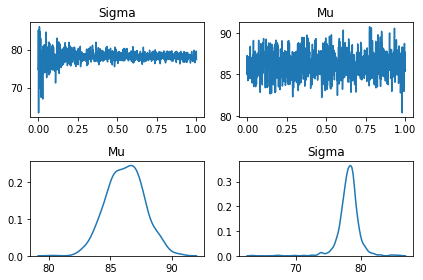

In [46]:
#define initial values
y = np.load('examscores.npy')
nu = 80
tau2 = 16
alpha = 3
beta = 50
n_samples = 1000
#run function
A = gibbs(y, nu, tau2, alpha, beta, n_samples)
#plot
mu = A[:,0]
sigma2 = A[:,1]
n = np.linspace(0,1,1000)
plt.subplot(221)
plt.plot(n,sigma2)
plt.title("Sigma")
plt.subplot(222)
plt.plot(n,mu)
plt.title("Mu")
#using kdeplot
plt.subplot(223)
sbn.kdeplot(mu)
plt.title("Mu")
plt.subplot(224)
sbn.kdeplot(sigma2)
plt.title("Sigma")
plt.tight_layout()
plt.show()

Implement `LDACGS.initialize()`.
By randomly assigning initial topics, fill in the count matrices and topic assignment dictionary.

Initializint $nmz$, $nzw$, and $nz$ to be zero arrays of the correct size.
Then, in the second for loop, assiging n z to be a random integer in the correct range of topics.
In the increment step, figuring out the correct indices to increment by one for each of the three arrays.
Finally, assigning $topics$ as given.

`LDACGS._sweep()` iterates through each word of each document.
It calls `LDACGS._conditional()` to get the conditional distribution at each iteration.

Note that the first part of this method will undo what `LDACGS.initialize()` did.
Then we will use the conditional distribution (instead of the uniform distribution we used previously) to pick a more accurate topic assignment.
Finally, the latter part repeats what we did in `LDACGS.initialize()`, but does so using this more accurate topic assignment.

The argument `filename` is the name and location of a .txt file, where each line is considered a document.
The corpus is built by `LDACGS.buildCorpus()`, and stopwords are removed (if argument `stopwords` is provided).
Burn in the Gibbs sampler, computing and saving the log-likelihood with the method `_loglikelihood()`.
After the burn in, iterate further, accumulating count matrices, by adding `nzw` and `nmz` to `total_nzw` and `total_nmz` respectively, where only every `sample_rate`th iteration is added. 
Saving each log-likelihood.

In [58]:
class LDACGS:
    """Do LDA with Gibbs Sampling."""

    def __init__(self, n_topics, alpha=0.1, beta=0.1):
        """Initialize system parameters."""
        self.n_topics = n_topics
        self.alpha = alpha
        self.beta = beta

    def buildCorpus(self, filename, stopwords_file=None):
        """Read the given filename and build the vocabulary."""
        with open(filename, 'r') as infile:
            doclines = [line.rstrip().lower().split(' ') for line in infile]
        n_docs = len(doclines)
        self.vocab = list({v for doc in doclines for v in doc})
        if stopwords_file:
            with open(stopwords_file, 'r') as stopfile:
                stops = stopfile.read().split()
            self.vocab = [x for x in self.vocab if x not in stops]
            self.vocab.sort()
        self.documents = []
        for i in range(n_docs):
            self.documents.append({})
            for j in range(len(doclines[i])):
                if doclines[i][j] in self.vocab:
                    self.documents[i][j] = self.vocab.index(doclines[i][j])

    def initialize(self):
        """Initialize the three count matrices."""
        self.n_words = len(self.vocab)
        self.n_docs = len(self.documents)
        
        # Initialize the three count matrices.
        # The (i,j) entry of self.nmz is the number of words in document i assigned to topic j.
        self.nmz = np.zeros((self.n_docs, self.n_topics))
        # The (i,j) entry of self.nzw is the number of times term j is assigned to topic i.
        self.nzw = np.zeros((self.n_topics, self.n_words))
        # The (i)-th entry is the number of times topic i is assigned in the corpus.
        self.nz = np.zeros(self.n_topics)

        # Initialize the topic assignment dictionary.
        self.topics = {} # key-value pairs of form (m,i):z

        for m in range(self.n_docs):
            for i in self.documents[m]:
                # Get random topic assignment, i.e. z = ...
                z = random.randint(0,self.n_topics-1)
                # Increment count matrices
                self.nmz[m,z] += 1
                self.nzw[z, self.documents[m][i]] += 1
                self.nz[z] += 1
                # Store topic assignment, i.e. self.topics[(m,i)]=z
                self.topics[(m,i)] = z

    def sample(self,filename, burnin=100, sample_rate=10, n_samples=10, stopwords_file=None):
        self.buildCorpus(filename, stopwords_file)
        self.initialize()
        self.total_nzw = np.zeros((self.n_topics, self.n_words))
        self.total_nmz = np.zeros((self.n_docs, self.n_topics))
        self.logprobs = np.zeros(burnin + sample_rate*n_samples)
        for i in range(burnin):
            # Sweep and store log likelihood.
            self._sweep()
            self.logprobs[i] = self._loglikelihood()
            
        for i in range(n_samples*sample_rate):
            # Sweep and store log likelihood
            self._sweep()
            self.logprobs[burnin + i] = self._loglikelihood()
            if not i % sample_rate:
                # accumulate counts
                self.total_nzw += self.nzw
                self.total_nmz += self.nmz

    def phi(self):
        phi = self.total_nzw + self.beta
        self._phi = phi / np.sum(phi, axis=1)[:,np.newaxis]

    def theta(self):
        theta = self.total_nmz + self.alpha
        self._theta = theta / np.sum(theta, axis=1)[:,np.newaxis]

    def topterms(self,n_terms=10):
        self.phi()
        self.theta()
        vec = np.atleast_2d(np.arange(0,self.n_words))
        topics = []
        for k in range(self.n_topics):
            probs = np.atleast_2d(self._phi[k,:])
            mat = np.append(probs,vec,0)
            sind = np.array([mat[:,i] for i in np.argsort(mat[0])]).T
            topics.append([self.vocab[int(sind[1,self.n_words - 1 - i])] for i in range(n_terms)])
        return topics

    def toplines(self,n_lines=5):
        lines = np.zeros((self.n_topics,n_lines))
        for i in range(self.n_topics):
            args = np.argsort(self._theta[:,i]).tolist()
            args.reverse()
            lines[i,:] = np.array(args)[0:n_lines] + 1
        return lines

    def _removeStopwords(self, stopwords):
        return [x for x in self.vocab if x not in stopwords]

    def _conditional(self, m, w):
        dist = (self.nmz[m,:] + self.alpha) * (self.nzw[:,w] + self.beta) / (self.nz + self.beta*self.n_words)
        return dist / np.sum(dist)

    def _sweep(self):
        for m in range(self.n_docs):
            for i in self.documents[m]:
                # Retrieve vocab index for i-th word in document m.
                index = self.documents[m][i]
                # Retrieve topic assignment for i-th word in document m.
                assignment = self.topics[(m,i)]
                # Decrement count matrices.
                self.nmz[m,assignment] -= 1
                self.nzw[assignment, self.documents[m][i]] -= 1
                self.nz[assignment] -= 1
                # Get conditional distribution.
                prob = self._conditional(m, index)
                # Sample new topic assignment.
                k = np.argmax(np.random.multinomial(1,prob))
                # Increment count matrices.
                self.nmz[m,k] += 1
                self.nzw[k, self.documents[m][i]] += 1
                self.nz[k] += 1
                # Store new topic assignment.
                self.topics[(m,i)] = k

    def _loglikelihood(self):
        lik = 0

        for z in range(self.n_topics):
            lik += np.sum(gammaln(self.nzw[z,:] + self.beta)) - gammaln(np.sum(self.nzw[z,:] + self.beta))
            lik -= self.n_words * gammaln(self.beta) - gammaln(self.n_words*self.beta)

        for m in range(self.n_docs):
            lik += np.sum(gammaln(self.nmz[m,:] + self.alpha)) - gammaln(np.sum(self.nmz[m,:] + self.alpha))
            lik -= self.n_topics * gammaln(self.alpha) - gammaln(self.n_topics*self.alpha)

        return lik

Create an `LDACGS` object with $20$ topics, letting $\alpha$ and $\beta$ be the default values.
Run the Gibbs sampler, with a burn in of $100$ iterations, accumulating $10$ samples, only keeping the results of every $10$th sweep.
Use `stopwords.txt` as the stopwords file.

Plot the log-likelihoods.

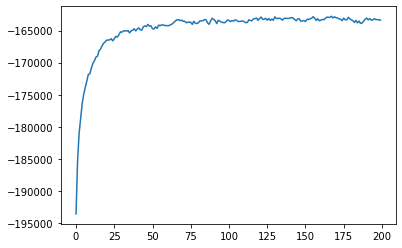

In [59]:
#define variable from our class and run the sample function to find the plot
A = LDACGS(20)
A.sample('reagan.txt', stopwords_file = 'stopwords.txt')
#plot
plt.plot(A.logprobs)
plt.show()

Using `topterms()` to examine the topics for Reagan's addresses.
Come up with labels for each topic.
If `ntopics=20` and `n=10`, we will get the top $10$ words that represent each of the $20$ topics; for each topic, deciding what these ten words jointly represent.

In [61]:
#find the 20 topics with 10 words. 
print("Topic: Finance")
print(A.topterms()[0])

print("Topic: Politics")
print(A.topterms()[1])

print("Topic: America")
print(A.topterms()[2])

print("Topic: People")
print(A.topterms()[3])

print("Topic: Heroism")
print(A.topterms()[4])

print("Topic: Treasury")
print(A.topterms()[5])

print("Topic: Russia")
print(A.topterms()[6])

print("Topic: NASA")
print(A.topterms()[7])

print("Topic: State of the Union")
print(A.topterms()[8])

print("Topic: Finance")
print(A.topterms()[9])

print("Topic: President")
print(A.topterms()[10])

print("Topic: America")
print(A.topterms()[11])

print("Topic: America")
print(A.topterms()[12])

print("Topic: Finance")
print(A.topterms()[13])

print("Topic: Foreign Policy")
print(A.topterms()[14])

print("Topic: Private")
print(A.topterms()[15])

print("Topic: Work Force")
print(A.topterms()[16])

print("Topic: Provide")
print(A.topterms()[17])

print("Topic: State of the Union")
print(A.topterms()[18])

print("Topic: Executive Branch")
print(A.topterms()[19])


Topic: Finance
['interest', 'percent', 'inflation', 'rates', 'rate', '--', 'increased', 'things', 'economic', 'years,']
Topic: Politics
['bipartisan', 'commission', 'senate', 'now,', 'leader', 'majority', 'protect', 'americans', 'join', 'house']
Topic: America
['god', 'bless', 'you,', '.', 'america.', 'you.', 'franklin', 'rising', 'roosevelt', 'setting']
Topic: People
['day', 'called', 'start', 'stop', "you'll", 'spreading', 'million', "we're", 'people.', 'fear']
Topic: Heroism
['safety.', 'heroism', 'crash', 'helicopter', 'wounded', 'plane', 'open', 'explosion', 'land', 'home.']
Topic: Treasury
['programs', 'federal', 'social', 'government', 'states', 'local', 'welfare', 'billion', 'years', '--']
Topic: Russia
['defense', 'soviet', 'security', 'nuclear', 'arms', 'military', 'national', 'peace', "we've", 'world']
Topic: NASA
['space', 'build', 'develop', 'well,', 'millions', 'research', 'it.', 'people', 'yes,', 'earth.']
Topic: State of the Union
['mr.', 'members', 'congress,', 'speake